## Physics Informed Neural Networks to Approximate Solution of PDEs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
from Common import NeuralNet, MultiVariatePoly
import time
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

Consider the one-dimensional heat equation:

$$
u_t(t, x) = u_{xx}(t, x), \quad t\in[0,T], ~x\in [-1,1]
$$

with zero Dirichlet boundary conditions

$$
u_b(t, -1)=u_b(t,1)=0, 
$$

and initial condition

$$
u(x, 0) = u_0(x) = - \sin(\pi x)
$$

We want to obtain an approximate solution of the heat equation $u : [0,T]\times[-1,1] \mapsto R$ with physics informed neural networks (PINNs).

To do so, we approximate the underlying solution with a feedforward dense neural network with tunable parameters $\theta$:

$$
u_\theta(t,x) \approx u(t,x)
$$
Define the following residuals:

   - Interior residual given by,
   
        $$r_{int,\theta}(t, x):=  u_{\theta, t}(x,t) - u_{\theta, xx}(x,t), \quad \forall ~t \in [0,T],~ x \in [-1,1].$$
        
   - Spatial boundary residual given by,
   
        $$r_{sb,\theta}(t,-1):= u_{\theta}(t,-1)- u_b(t,-1), \quad r_{sb,\theta}(t,1):= u_{\theta}(t,1)- u_b(t,1), \quad \forall t \in (0,T].$$
        
   - Temporal boundary residual given by,
   
        $$r_{tb,\theta}(x):= u_{\theta}(x,0) - u_0(x), \quad \forall x \in [-1,1].$$

and compute the corresponding loss functions:

$$
L_{int}(\theta) = \int_{[0,T]\times[-1,1]}r_{int,\theta}^2(t, x) dtdx, \quad
L_{sb}(\theta) = \int_{[0,T]}r_{sb,\theta}^2(t,-1) dt + \int_{[0,T]}r_{sb,\theta}^2(t,1)dt, \quad
L_{tb}(\theta) = \int_{[-1,1]}r_{tb,\theta}^2(x) dx
$$

The loss functions include integrals that can be approximated by suitable quadrature rule. We use quasi Monte-Carlo and accordingly define the following training sets

$$
S_{int} =\{y_n\}, \quad 1 \leq n \leq N_{int},\quad y_n = (x,t)_n \in D_T,
$$

$$
S_{sb, -1} =\{t_n, u_b(t_n,-1) \}, \quad1 \leq n \leq N_{sb}, t_n \in [0,T],
$$

$$
S_{sb, 1} =\{t_n, u_b(t_n,1) \}, \quad1 \leq n \leq N_{sb}, t_n \in [0,T],
$$

$$
S_{tb}=\{x_n, u_0(x_n)\}\quad  1 \leq n \leq N_{tb}, x_n \in [-1,1].
$$

with the training inputs points corresponding to low-discrepancy Sobol sequences.

$$
L_{int}(\theta) = \frac{1}{N_{int}}\sum_{i=1}^{N_{int}}r_{int,\theta}^2(y_n), \quad
L_{sb}(\theta) = \frac{1}{N_{sb}}\sum_{i=1}^{N_{sb}}r_{sb,\theta}^2(t_n,-1) + \frac{1}{N_{sb}}\sum_{i=1}^{N_{sb}}r_{sb,\theta}^2(t_n,1), \quad
L_{tb}(\theta) = \frac{1}{N_{tb}}\sum_{i=1}^{N_{tb}}r_{tb,\theta}^2(x_n)
$$

and solve the following minimization problem

$$
\theta^\ast = argmin_{\theta} \Big(L_{int}(\theta) + \lambda_u L_u(\theta)\Big)
$$

with

$$
L_u(\theta) = L_{tb}(\theta) + L_{sb}(\theta)
$$



In [ ]:
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_

        # Extrema of the solution domain (t,x) in [0,0.1]x[-1,1]
        self.domain_extrema = torch.tensor([[0, 0.1],  # Time dimension
                                            [-1, 1]])  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = 10

        # FF Dense NN to approximate the solution of the underlying heat equation
        self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=1,
                                              n_hidden_layers=4,
                                              neurons=20,
                                              regularization_param=0.,
                                              regularization_exp=2.,
                                              retrain_seed=42)
        '''self.approximate_solution = MultiVariatePoly(self.domain_extrema.shape[0], 3)'''

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int = self.assemble_datasets()

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    # Initial condition to solve the heat equation u0(x)=-sin(pi x)
    def initial_condition(self, x):
        return -torch.sin(np.pi * x)

    # Exact solution for the heat equation ut = u_xx with the IC above
    def exact_solution(self, inputs):
        t = inputs[:, 0]
        x = inputs[:, 1]

        u = -torch.exp(-np.pi ** 2 * t) * torch.sin(np.pi * x)
        return u

    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = self.initial_condition(input_tb[:, 1]).reshape(-1, 1)

        return input_tb, output_tb

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        output_sb_0 = torch.zeros((input_sb.shape[0], 1))
        output_sb_L = torch.zeros((input_sb.shape[0], 1))

        return torch.cat([input_sb_0, input_sb_L], 0), torch.cat([output_sb_0, output_sb_L], 0)

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()   # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()         # S_int

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2*self.space_dimensions*self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)

        return training_set_sb, training_set_tb, training_set_int

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        u_pred_tb = self.approximate_solution(input_tb)
        return u_pred_tb

    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions(self, input_sb):
        u_pred_sb = self.approximate_solution(input_sb)

        return u_pred_sb

    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True
        u = self.approximate_solution(input_int)

        # grad compute the gradient of a "SCALAR" function L with respect to some input nxm TENSOR Z=[[x1, y1],[x2,y2],[x3,y3],...,[xn,yn]], m=2
        # it returns grad_L = [[dL/dx1, dL/dy1],[dL/dx2, dL/dy2],[dL/dx3, dL/dy3],...,[dL/dxn, dL/dyn]]
        # Note: pytorch considers a tensor [u1, u2,u3, ... ,un] a vectorial function
        # whereas sum_u = u1 + u2 u3 + u4 + ... + un as a "scalar" one

        # In our case ui = u(xi), therefore the line below returns:
        # grad_u = [[dsum_u/dx1, dsum_u/dy1],[dsum_u/dx2, dsum_u/dy2],[dsum_u/dx3, dL/dy3],...,[dsum_u/dxm, dsum_u/dyn]]
        # and dsum_u/dxi = d(u1 + u2 u3 + u4 + ... + un)/dxi = d(u(x1) + u(x2) u3(x3) + u4(x4) + ... + u(xn))/dxi = dui/dxi
        grad_u = torch.autograd.grad(u.sum(), input_int, create_graph=True)[0]
        grad_u_t = grad_u[:, 0]
        grad_u_x = grad_u[:, 1]
        grad_u_xx = torch.autograd.grad(grad_u_x.sum(), input_int, create_graph=True)[0][:, 1]

        residual = grad_u_t - grad_u_xx
        return residual.reshape(-1, )

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=True):
        u_pred_sb = self.apply_boundary_conditions(inp_train_sb)
        u_pred_tb = self.apply_initial_condition(inp_train_tb)

        assert (u_pred_sb.shape[1] == u_train_sb.shape[1])
        assert (u_pred_tb.shape[1] == u_train_tb.shape[1])


        r_int = self.compute_pde_residual(inp_train_int)
        r_sb = u_train_sb - u_pred_sb
        r_tb = u_train_tb - u_pred_tb

        loss_sb = torch.mean(abs(r_sb) ** 2)
        loss_tb = torch.mean(abs(r_tb) ** 2)
        loss_int = torch.mean(abs(r_int) ** 2)

        loss_u = loss_sb + loss_tb

        loss = torch.log10(self.lambda_u * (loss_sb + loss_tb) + loss_int)
        if verbose: print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(loss_u).item(), 4), "| Function Loss: ", round(torch.log10(loss_int).item(), 4))

        return loss

    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_sb, self.training_set_tb, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history

    ################################################################################################
    def plotting(self):
        inputs = self.soboleng.draw(100000)
        inputs = self.convert(inputs)

        output = self.approximate_solution(inputs).reshape(-1, )
        exact_output = self.exact_solution(inputs).reshape(-1, )

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=exact_output.detach(), cmap="jet")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")
        im2 = axs[1].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=output.detach(), cmap="jet")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("t")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[0].set_title("Exact Solution")
        axs[1].set_title("Approximate Solution")

        plt.show()

        err = (torch.mean((output - exact_output) ** 2) / torch.mean(exact_output ** 2)) ** 0.5 * 100
        print("L2 Relative Error Norm: ", err.item(), "%")


In [27]:
# Solve the heat equation:
# u_t = u_xx, (t,x) in [0, 0.1]x[-1,1]
# with zero dirichlet BC and
# u(x,0)= -sin(pi x)

n_int = 256
n_sb = 64
n_tb = 64

pinn = Pinns(n_int, n_sb, n_tb)

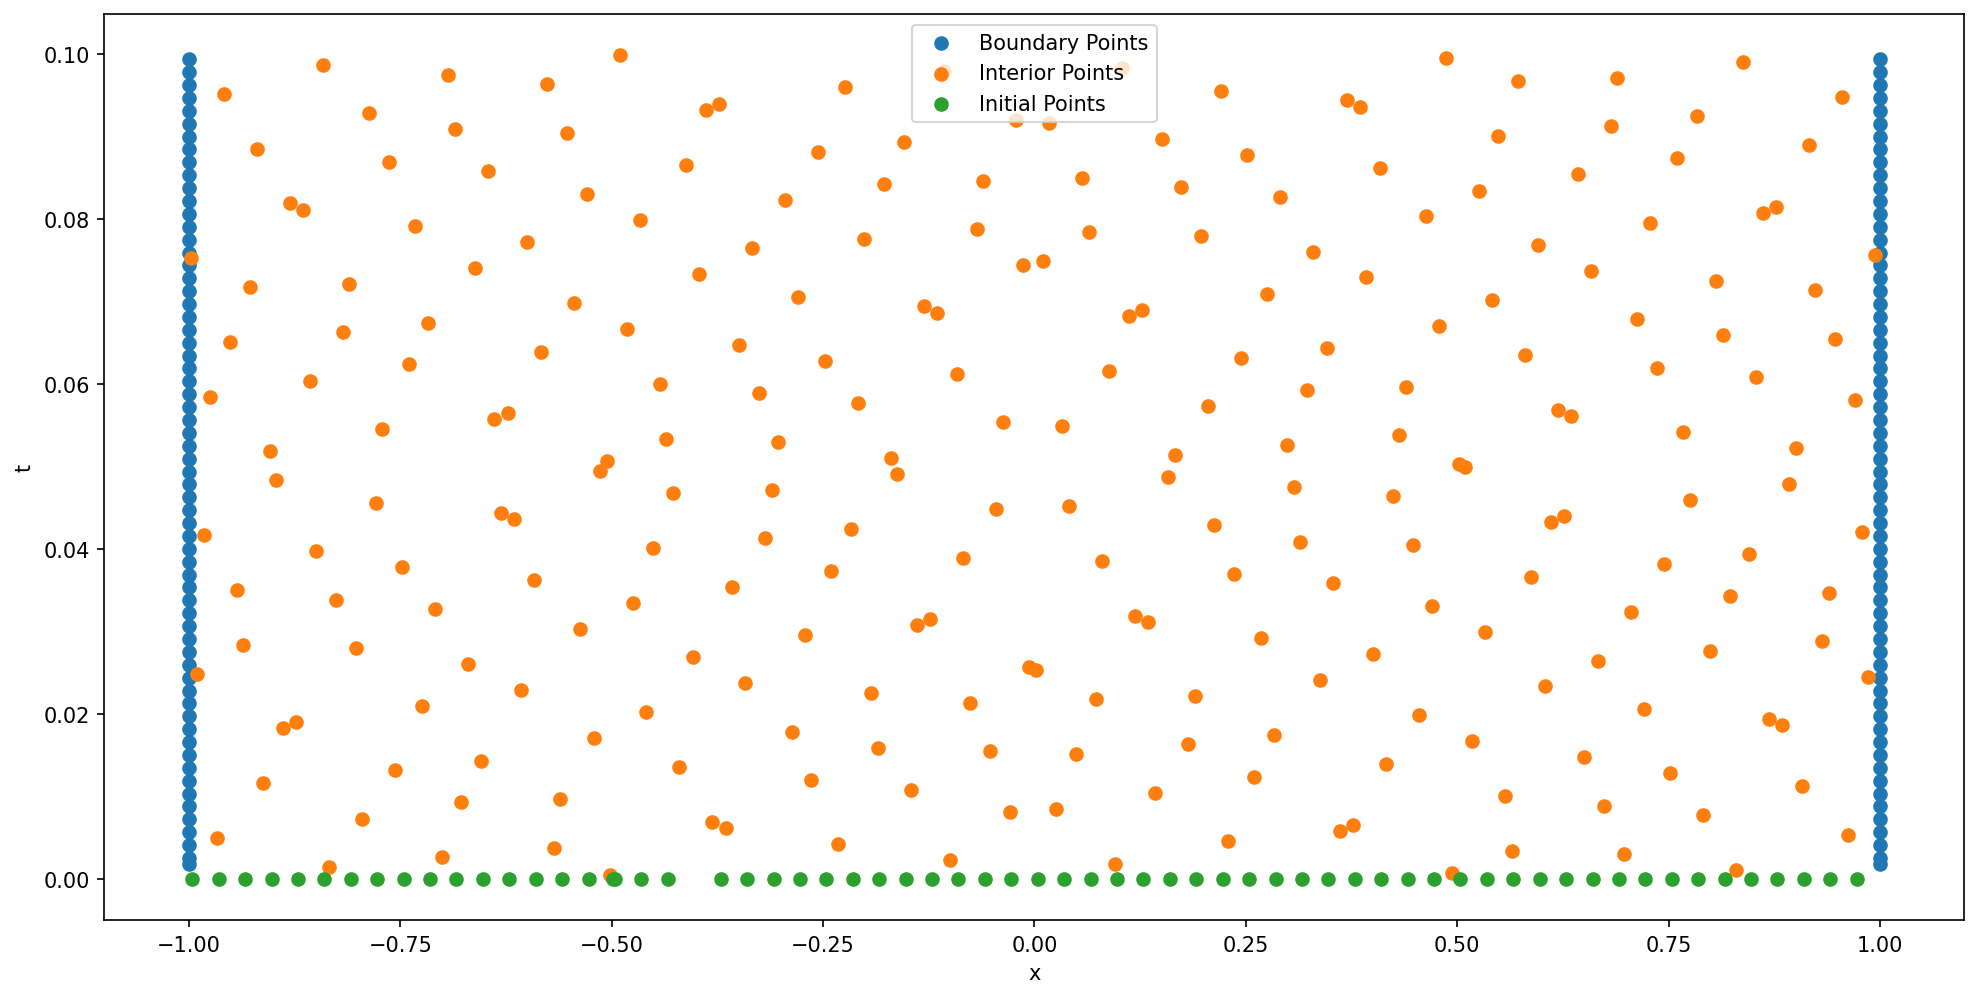

In [28]:
# Plot the input training points
input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_tb_, output_tb_ = pinn.add_temporal_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()

plt.figure(figsize=(16, 8), dpi=150)
plt.scatter(input_sb_[:, 1].detach().numpy(), input_sb_[:, 0].detach().numpy(), label="Boundary Points")
plt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 0].detach().numpy(), label="Interior Points")
plt.scatter(input_tb_[:, 1].detach().numpy(), input_tb_[:, 0].detach().numpy(), label="Initial Points")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

In [29]:
n_epochs = 1
optimizer_LBFGS = optim.LBFGS(pinn.approximate_solution.parameters(),
                              lr=float(0.5),
                              max_iter=50000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)
optimizer_ADAM = optim.Adam(pinn.approximate_solution.parameters(),
                            lr=float(0.005))

################################  0  ################################
Total loss:  1.6045 | PDE Loss:  -0.0008 | Function Loss:  1.4806
Total loss:  1.5325 | PDE Loss:  -0.1129 | Function Loss:  1.4211
Total loss:  1.1978 | PDE Loss:  0.0321 | Function Loss:  0.699
Total loss:  1.0031 | PDE Loss:  -0.1947 | Function Loss:  0.5664
Total loss:  0.8536 | PDE Loss:  -0.2951 | Function Loss:  0.316
Total loss:  0.6773 | PDE Loss:  -0.3916 | Function Loss:  -0.1561
Total loss:  0.5714 | PDE Loss:  -0.5138 | Function Loss:  -0.1777
Total loss:  0.5288 | PDE Loss:  -0.55 | Function Loss:  -0.2511
Total loss:  0.5123 | PDE Loss:  -0.5597 | Function Loss:  -0.3039
Total loss:  0.4972 | PDE Loss:  -0.5746 | Function Loss:  -0.3196
Total loss:  0.4785 | PDE Loss:  -0.5971 | Function Loss:  -0.3181
Total loss:  0.4607 | PDE Loss:  -0.6164 | Function Loss:  -0.3282
Total loss:  0.4429 | PDE Loss:  -0.6339 | Function Loss:  -0.3468
Total loss:  0.4211 | PDE Loss:  -0.6494 | Function Loss:  -0.4034
To

Total loss:  -1.4019 | PDE Loss:  -2.7309 | Function Loss:  -1.6766
Total loss:  -1.4091 | PDE Loss:  -2.7255 | Function Loss:  -1.6953
Total loss:  -1.4171 | PDE Loss:  -2.7189 | Function Loss:  -1.7175
Total loss:  -1.4241 | PDE Loss:  -2.716 | Function Loss:  -1.7344
Total loss:  -1.4306 | PDE Loss:  -2.7019 | Function Loss:  -1.7636
Total loss:  -1.4382 | PDE Loss:  -2.692 | Function Loss:  -1.7921
Total loss:  -1.444 | PDE Loss:  -2.6872 | Function Loss:  -1.8118
Total loss:  -1.4531 | PDE Loss:  -2.6814 | Function Loss:  -1.8417
Total loss:  -1.4628 | PDE Loss:  -2.6804 | Function Loss:  -1.8672
Total loss:  -1.4727 | PDE Loss:  -2.6834 | Function Loss:  -1.8879
Total loss:  -1.4841 | PDE Loss:  -2.6916 | Function Loss:  -1.9045
Total loss:  -1.4935 | PDE Loss:  -2.7055 | Function Loss:  -1.9067
Total loss:  -1.508 | PDE Loss:  -2.7266 | Function Loss:  -1.911
Total loss:  -1.5285 | PDE Loss:  -2.7635 | Function Loss:  -1.9075
Total loss:  -1.5486 | PDE Loss:  -2.8106 | Function 

Total loss:  -2.4382 | PDE Loss:  -3.7666 | Function Loss:  -2.7134
Total loss:  -2.442 | PDE Loss:  -3.7738 | Function Loss:  -2.7142
Total loss:  -2.4467 | PDE Loss:  -3.7812 | Function Loss:  -2.7167
Total loss:  -2.4531 | PDE Loss:  -3.7824 | Function Loss:  -2.7275
Total loss:  -2.4602 | PDE Loss:  -3.783 | Function Loss:  -2.7406
Total loss:  -2.4664 | PDE Loss:  -3.7821 | Function Loss:  -2.7532
Total loss:  -2.4703 | PDE Loss:  -3.7855 | Function Loss:  -2.7577
Total loss:  -2.4743 | PDE Loss:  -3.7947 | Function Loss:  -2.7567
Total loss:  -2.4778 | PDE Loss:  -3.8006 | Function Loss:  -2.7582
Total loss:  -2.4815 | PDE Loss:  -3.8091 | Function Loss:  -2.7575
Total loss:  -2.4847 | PDE Loss:  -3.8164 | Function Loss:  -2.7571
Total loss:  -2.488 | PDE Loss:  -3.8212 | Function Loss:  -2.759
Total loss:  -2.492 | PDE Loss:  -3.8324 | Function Loss:  -2.7571
Total loss:  -2.4973 | PDE Loss:  -3.8398 | Function Loss:  -2.7605
Total loss:  -2.5018 | PDE Loss:  -3.8589 | Function 

Total loss:  -2.9228 | PDE Loss:  -4.5596 | Function Loss:  -3.0367
Total loss:  -2.9296 | PDE Loss:  -4.549 | Function Loss:  -3.0489
Total loss:  -2.9368 | PDE Loss:  -4.5352 | Function Loss:  -3.063
Total loss:  -2.9431 | PDE Loss:  -4.5229 | Function Loss:  -3.0757
Total loss:  -2.9496 | PDE Loss:  -4.5101 | Function Loss:  -3.0893
Total loss:  -2.9565 | PDE Loss:  -4.4937 | Function Loss:  -3.1054
Total loss:  -2.9626 | PDE Loss:  -4.4771 | Function Loss:  -3.1211
Total loss:  -2.9537 | PDE Loss:  -4.4486 | Function Loss:  -3.1212
Total loss:  -2.9658 | PDE Loss:  -4.4678 | Function Loss:  -3.13
Total loss:  -2.9703 | PDE Loss:  -4.4608 | Function Loss:  -3.1399
Total loss:  -2.9753 | PDE Loss:  -4.46 | Function Loss:  -3.1476
Total loss:  -2.9828 | PDE Loss:  -4.4596 | Function Loss:  -3.159
Total loss:  -2.99 | PDE Loss:  -4.457 | Function Loss:  -3.1713
Total loss:  -2.9904 | PDE Loss:  -4.4396 | Function Loss:  -3.1812
Total loss:  -2.9941 | PDE Loss:  -4.453 | Function Loss: 

Total loss:  -3.4103 | PDE Loss:  -5.0141 | Function Loss:  -3.5347
Total loss:  -3.4138 | PDE Loss:  -5.022 | Function Loss:  -3.5367
Total loss:  -3.4174 | PDE Loss:  -5.0273 | Function Loss:  -3.5398
Total loss:  -3.4193 | PDE Loss:  -5.0299 | Function Loss:  -3.5414
Total loss:  -3.4223 | PDE Loss:  -5.03 | Function Loss:  -3.5454
Total loss:  -3.4249 | PDE Loss:  -5.0281 | Function Loss:  -3.5495
Total loss:  -3.4286 | PDE Loss:  -5.0269 | Function Loss:  -3.5548
Total loss:  -3.4361 | PDE Loss:  -5.023 | Function Loss:  -3.5662
Total loss:  -3.4434 | PDE Loss:  -5.0195 | Function Loss:  -3.5774
Total loss:  -3.4503 | PDE Loss:  -5.0177 | Function Loss:  -3.5875
Total loss:  -3.4548 | PDE Loss:  -5.0172 | Function Loss:  -3.5938
Total loss:  -3.461 | PDE Loss:  -5.0135 | Function Loss:  -3.6037
Total loss:  -3.4647 | PDE Loss:  -5.0142 | Function Loss:  -3.6087
Total loss:  -3.4667 | PDE Loss:  -5.0135 | Function Loss:  -3.6118
Total loss:  -3.4689 | PDE Loss:  -5.0138 | Function 

Total loss:  -3.7916 | PDE Loss:  -5.6092 | Function Loss:  -3.8633
Total loss:  -3.7957 | PDE Loss:  -5.6088 | Function Loss:  -3.8683
Total loss:  -3.7983 | PDE Loss:  -5.6049 | Function Loss:  -3.872
Total loss:  -3.8022 | PDE Loss:  -5.6069 | Function Loss:  -3.8762
Total loss:  -3.8078 | PDE Loss:  -5.6092 | Function Loss:  -3.8825
Total loss:  -3.8133 | PDE Loss:  -5.6051 | Function Loss:  -3.8898
Total loss:  -3.817 | PDE Loss:  -5.6056 | Function Loss:  -3.8941
Total loss:  -3.8211 | PDE Loss:  -5.5983 | Function Loss:  -3.9005
Total loss:  -3.8242 | PDE Loss:  -5.5945 | Function Loss:  -3.905
Total loss:  -3.8258 | PDE Loss:  -5.588 | Function Loss:  -3.9083
Total loss:  -3.8272 | PDE Loss:  -5.5854 | Function Loss:  -3.9105
Total loss:  -3.8284 | PDE Loss:  -5.5843 | Function Loss:  -3.9121
Total loss:  -3.8304 | PDE Loss:  -5.5812 | Function Loss:  -3.9153
Total loss:  -3.8334 | PDE Loss:  -5.5838 | Function Loss:  -3.9183
Total loss:  -3.8373 | PDE Loss:  -5.5885 | Function

Total loss:  -4.0294 | PDE Loss:  -5.96 | Function Loss:  -4.0836
Total loss:  -4.0312 | PDE Loss:  -5.9562 | Function Loss:  -4.0862
Total loss:  -4.0325 | PDE Loss:  -5.9481 | Function Loss:  -4.0887
Total loss:  -4.0333 | PDE Loss:  -5.9414 | Function Loss:  -4.0906
Total loss:  -4.0339 | PDE Loss:  -5.9392 | Function Loss:  -4.0916
Total loss:  -4.0343 | PDE Loss:  -5.9401 | Function Loss:  -4.0919
Total loss:  -4.0347 | PDE Loss:  -5.9431 | Function Loss:  -4.092
Total loss:  -4.0352 | PDE Loss:  -5.9491 | Function Loss:  -4.0917
Total loss:  -4.0359 | PDE Loss:  -5.9559 | Function Loss:  -4.0915
Total loss:  -4.0366 | PDE Loss:  -5.9647 | Function Loss:  -4.0911
Total loss:  -4.0374 | PDE Loss:  -5.9718 | Function Loss:  -4.0911
Total loss:  -4.0382 | PDE Loss:  -5.979 | Function Loss:  -4.0911
Total loss:  -4.0391 | PDE Loss:  -5.9835 | Function Loss:  -4.0914
Total loss:  -4.0397 | PDE Loss:  -5.9881 | Function Loss:  -4.0916
Total loss:  -4.0403 | PDE Loss:  -5.9891 | Function

Total loss:  -4.1932 | PDE Loss:  -6.4405 | Function Loss:  -4.2185
Total loss:  -4.1967 | PDE Loss:  -6.4518 | Function Loss:  -4.2215
Total loss:  -4.2007 | PDE Loss:  -6.4734 | Function Loss:  -4.2246
Total loss:  -4.2056 | PDE Loss:  -6.4696 | Function Loss:  -4.23
Total loss:  -4.2109 | PDE Loss:  -6.486 | Function Loss:  -4.2346
Total loss:  -4.2167 | PDE Loss:  -6.4822 | Function Loss:  -4.241
Total loss:  -4.2203 | PDE Loss:  -6.4212 | Function Loss:  -4.2485
Total loss:  -4.2274 | PDE Loss:  -6.4321 | Function Loss:  -4.2553
Total loss:  -4.2325 | PDE Loss:  -6.4429 | Function Loss:  -4.2601
Total loss:  -4.2375 | PDE Loss:  -6.455 | Function Loss:  -4.2646
Total loss:  -4.2415 | PDE Loss:  -6.4426 | Function Loss:  -4.2698
Total loss:  -4.2437 | PDE Loss:  -6.4498 | Function Loss:  -4.2716
Total loss:  -4.2464 | PDE Loss:  -6.4619 | Function Loss:  -4.2736
Total loss:  -4.2495 | PDE Loss:  -6.4707 | Function Loss:  -4.2764
Total loss:  -4.2528 | PDE Loss:  -6.4942 | Function 

Total loss:  -4.377 | PDE Loss:  -6.5809 | Function Loss:  -4.405
Total loss:  -4.3786 | PDE Loss:  -6.5925 | Function Loss:  -4.406
Total loss:  -4.38 | PDE Loss:  -6.6025 | Function Loss:  -4.4069
Total loss:  -4.3813 | PDE Loss:  -6.6026 | Function Loss:  -4.4082
Total loss:  -4.3824 | PDE Loss:  -6.6127 | Function Loss:  -4.4088
Total loss:  -4.3836 | PDE Loss:  -6.6145 | Function Loss:  -4.4099
Total loss:  -4.3855 | PDE Loss:  -6.6156 | Function Loss:  -4.4119
Total loss:  -4.3878 | PDE Loss:  -6.604 | Function Loss:  -4.415
Total loss:  -4.39 | PDE Loss:  -6.6013 | Function Loss:  -4.4175
Total loss:  -4.3913 | PDE Loss:  -6.5974 | Function Loss:  -4.4192
Total loss:  -4.3926 | PDE Loss:  -6.6023 | Function Loss:  -4.4202
Total loss:  -4.3934 | PDE Loss:  -6.6082 | Function Loss:  -4.4207
Total loss:  -4.3939 | PDE Loss:  -6.6107 | Function Loss:  -4.4211
Total loss:  -4.3946 | PDE Loss:  -6.6161 | Function Loss:  -4.4215
Total loss:  -4.3952 | PDE Loss:  -6.6181 | Function Loss

Total loss:  -4.5298 | PDE Loss:  -6.5955 | Function Loss:  -4.5689
Total loss:  -4.5302 | PDE Loss:  -6.6044 | Function Loss:  -4.5684
Total loss:  -4.5306 | PDE Loss:  -6.6086 | Function Loss:  -4.5685
Total loss:  -4.531 | PDE Loss:  -6.6132 | Function Loss:  -4.5685
Total loss:  -4.5316 | PDE Loss:  -6.6141 | Function Loss:  -4.569
Total loss:  -4.532 | PDE Loss:  -6.6163 | Function Loss:  -4.5693
Total loss:  -4.5325 | PDE Loss:  -6.6142 | Function Loss:  -4.5701
Total loss:  -4.5331 | PDE Loss:  -6.6126 | Function Loss:  -4.5708
Total loss:  -4.5338 | PDE Loss:  -6.6101 | Function Loss:  -4.5718
Total loss:  -4.5344 | PDE Loss:  -6.6088 | Function Loss:  -4.5726
Total loss:  -4.5352 | PDE Loss:  -6.6085 | Function Loss:  -4.5735
Total loss:  -4.5362 | PDE Loss:  -6.6092 | Function Loss:  -4.5745
Total loss:  -4.5374 | PDE Loss:  -6.6155 | Function Loss:  -4.5753
Total loss:  -4.5384 | PDE Loss:  -6.615 | Function Loss:  -4.5765
Total loss:  -4.5396 | PDE Loss:  -6.6247 | Function

Total loss:  -4.6961 | PDE Loss:  -6.7867 | Function Loss:  -4.7328
Total loss:  -4.6961 | PDE Loss:  -6.7876 | Function Loss:  -4.7328
Total loss:  -4.6962 | PDE Loss:  -6.7893 | Function Loss:  -4.7328
Total loss:  -4.6963 | PDE Loss:  -6.7902 | Function Loss:  -4.7328
Total loss:  -4.6964 | PDE Loss:  -6.7917 | Function Loss:  -4.7328
Total loss:  -4.6965 | PDE Loss:  -6.7921 | Function Loss:  -4.7329
Total loss:  -4.6967 | PDE Loss:  -6.7935 | Function Loss:  -4.7329
Total loss:  -4.6968 | PDE Loss:  -6.7933 | Function Loss:  -4.733
Total loss:  -4.697 | PDE Loss:  -6.7958 | Function Loss:  -4.733
Total loss:  -4.6971 | PDE Loss:  -6.7962 | Function Loss:  -4.7331
Total loss:  -4.6974 | PDE Loss:  -6.7977 | Function Loss:  -4.7333
Total loss:  -4.6978 | PDE Loss:  -6.7993 | Function Loss:  -4.7336
Total loss:  -4.6979 | PDE Loss:  -6.8006 | Function Loss:  -4.7336
Total loss:  -4.6981 | PDE Loss:  -6.8019 | Function Loss:  -4.7337
Total loss:  -4.6983 | PDE Loss:  -6.8033 | Functio

Total loss:  -4.7851 | PDE Loss:  -6.8811 | Function Loss:  -4.8214
Total loss:  -4.7854 | PDE Loss:  -6.885 | Function Loss:  -4.8214
Total loss:  -4.7859 | PDE Loss:  -6.887 | Function Loss:  -4.8217
Total loss:  -4.7866 | PDE Loss:  -6.8882 | Function Loss:  -4.8224
Total loss:  -4.7873 | PDE Loss:  -6.8885 | Function Loss:  -4.8232
Total loss:  -4.7881 | PDE Loss:  -6.8866 | Function Loss:  -4.8242
Total loss:  -4.7887 | PDE Loss:  -6.885 | Function Loss:  -4.825
Total loss:  -4.7896 | PDE Loss:  -6.8822 | Function Loss:  -4.8262
Total loss:  -4.7904 | PDE Loss:  -6.8803 | Function Loss:  -4.8273
Total loss:  -4.7913 | PDE Loss:  -6.8805 | Function Loss:  -4.8281
Total loss:  -4.7922 | PDE Loss:  -6.8833 | Function Loss:  -4.829
Total loss:  -4.7932 | PDE Loss:  -6.8845 | Function Loss:  -4.8299
Total loss:  -4.7941 | PDE Loss:  -6.8899 | Function Loss:  -4.8304
Total loss:  -4.7946 | PDE Loss:  -6.8907 | Function Loss:  -4.8309
Total loss:  -4.7952 | PDE Loss:  -6.8921 | Function 

Total loss:  -4.9034 | PDE Loss:  -6.8858 | Function Loss:  -4.9512
Total loss:  -4.9039 | PDE Loss:  -6.8803 | Function Loss:  -4.9523
Total loss:  -4.9043 | PDE Loss:  -6.8783 | Function Loss:  -4.9531
Total loss:  -4.9049 | PDE Loss:  -6.8729 | Function Loss:  -4.9544
Total loss:  -4.9057 | PDE Loss:  -6.8674 | Function Loss:  -4.9559
Total loss:  -4.9064 | PDE Loss:  -6.8615 | Function Loss:  -4.9574
Total loss:  -4.907 | PDE Loss:  -6.8573 | Function Loss:  -4.9586
Total loss:  -4.9077 | PDE Loss:  -6.8534 | Function Loss:  -4.9599
Total loss:  -4.9082 | PDE Loss:  -6.8463 | Function Loss:  -4.9615
Total loss:  -4.9087 | PDE Loss:  -6.8446 | Function Loss:  -4.9622
Total loss:  -4.9091 | PDE Loss:  -6.8412 | Function Loss:  -4.9631
Total loss:  -4.9098 | PDE Loss:  -6.8408 | Function Loss:  -4.9639
Total loss:  -4.9107 | PDE Loss:  -6.8372 | Function Loss:  -4.9655
Total loss:  -4.9116 | PDE Loss:  -6.8364 | Function Loss:  -4.9665
Total loss:  -4.9128 | PDE Loss:  -6.8408 | Funct

Total loss:  -4.9753 | PDE Loss:  -6.9751 | Function Loss:  -5.0211
Total loss:  -4.9785 | PDE Loss:  -6.9746 | Function Loss:  -5.0247
Total loss:  -4.9845 | PDE Loss:  -6.9784 | Function Loss:  -5.0309
Total loss:  -4.9898 | PDE Loss:  -6.9605 | Function Loss:  -5.0389
Total loss:  -4.9946 | PDE Loss:  -6.955 | Function Loss:  -5.045
Total loss:  -4.9998 | PDE Loss:  -6.9496 | Function Loss:  -5.0516
Total loss:  -5.0032 | PDE Loss:  -6.9503 | Function Loss:  -5.0552
Total loss:  -5.0108 | PDE Loss:  -6.9726 | Function Loss:  -5.061
Total loss:  -5.0142 | PDE Loss:  -6.9812 | Function Loss:  -5.0637
Total loss:  -5.0177 | PDE Loss:  -6.9928 | Function Loss:  -5.0663
Total loss:  -5.0196 | PDE Loss:  -6.9926 | Function Loss:  -5.0685
Total loss:  -5.0228 | PDE Loss:  -7.02 | Function Loss:  -5.0689
Total loss:  -5.0248 | PDE Loss:  -7.0053 | Function Loss:  -5.0727
Total loss:  -5.0276 | PDE Loss:  -6.9992 | Function Loss:  -5.0767
Total loss:  -5.0313 | PDE Loss:  -7.0001 | Function 

Total loss:  -5.1638 | PDE Loss:  -7.0234 | Function Loss:  -5.2284
Total loss:  -5.1638 | PDE Loss:  -7.0223 | Function Loss:  -5.2286
Total loss:  -5.164 | PDE Loss:  -7.0208 | Function Loss:  -5.229
Total loss:  -5.1641 | PDE Loss:  -7.0199 | Function Loss:  -5.2293
Total loss:  -5.1642 | PDE Loss:  -7.0127 | Function Loss:  -5.2305
Total loss:  -5.1644 | PDE Loss:  -7.0145 | Function Loss:  -5.2306
Total loss:  -5.1647 | PDE Loss:  -7.0185 | Function Loss:  -5.2302
Total loss:  -5.1651 | PDE Loss:  -7.023 | Function Loss:  -5.23
Total loss:  -5.1656 | PDE Loss:  -7.0286 | Function Loss:  -5.2296
Total loss:  -5.166 | PDE Loss:  -7.034 | Function Loss:  -5.2293
Total loss:  -5.1664 | PDE Loss:  -7.0366 | Function Loss:  -5.2293
Total loss:  -5.1667 | PDE Loss:  -7.0397 | Function Loss:  -5.2292
Total loss:  -5.1672 | PDE Loss:  -7.0416 | Function Loss:  -5.2294
Total loss:  -5.1676 | PDE Loss:  -7.0432 | Function Loss:  -5.2297
Total loss:  -5.1681 | PDE Loss:  -7.0427 | Function Lo

Total loss:  -5.2776 | PDE Loss:  -7.2068 | Function Loss:  -5.332
Total loss:  -5.2779 | PDE Loss:  -7.2089 | Function Loss:  -5.332
Total loss:  -5.2784 | PDE Loss:  -7.2104 | Function Loss:  -5.3324
Total loss:  -5.2786 | PDE Loss:  -7.2116 | Function Loss:  -5.3325
Total loss:  -5.2788 | PDE Loss:  -7.213 | Function Loss:  -5.3325
Total loss:  -5.279 | PDE Loss:  -7.214 | Function Loss:  -5.3326
Total loss:  -5.2792 | PDE Loss:  -7.2147 | Function Loss:  -5.3327
Total loss:  -5.2793 | PDE Loss:  -7.215 | Function Loss:  -5.3329
Total loss:  -5.2795 | PDE Loss:  -7.215 | Function Loss:  -5.3331
Total loss:  -5.2798 | PDE Loss:  -7.2143 | Function Loss:  -5.3335
Total loss:  -5.2799 | PDE Loss:  -7.2131 | Function Loss:  -5.3337
Total loss:  -5.2802 | PDE Loss:  -7.211 | Function Loss:  -5.3344
Total loss:  -5.2802 | PDE Loss:  -7.2084 | Function Loss:  -5.3347
Total loss:  -5.2805 | PDE Loss:  -7.2033 | Function Loss:  -5.3358
Total loss:  -5.2806 | PDE Loss:  -7.2004 | Function Los

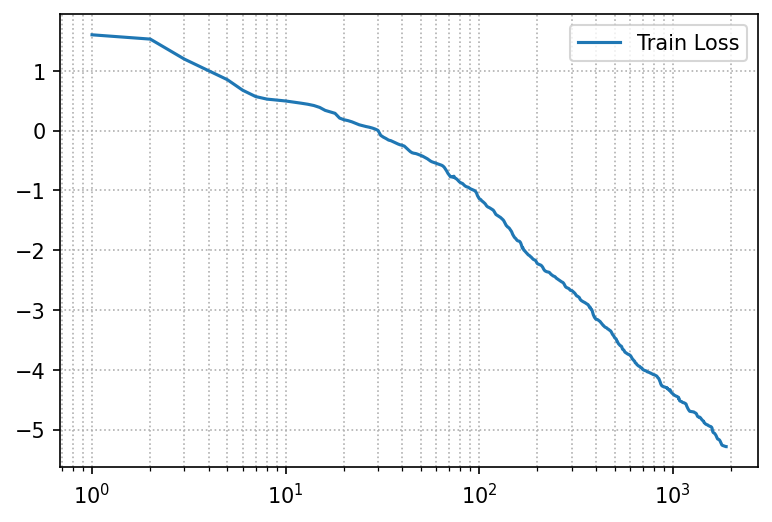

In [30]:
hist = pinn.fit(num_epochs=n_epochs,
                optimizer=optimizer_LBFGS,
                verbose=True)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

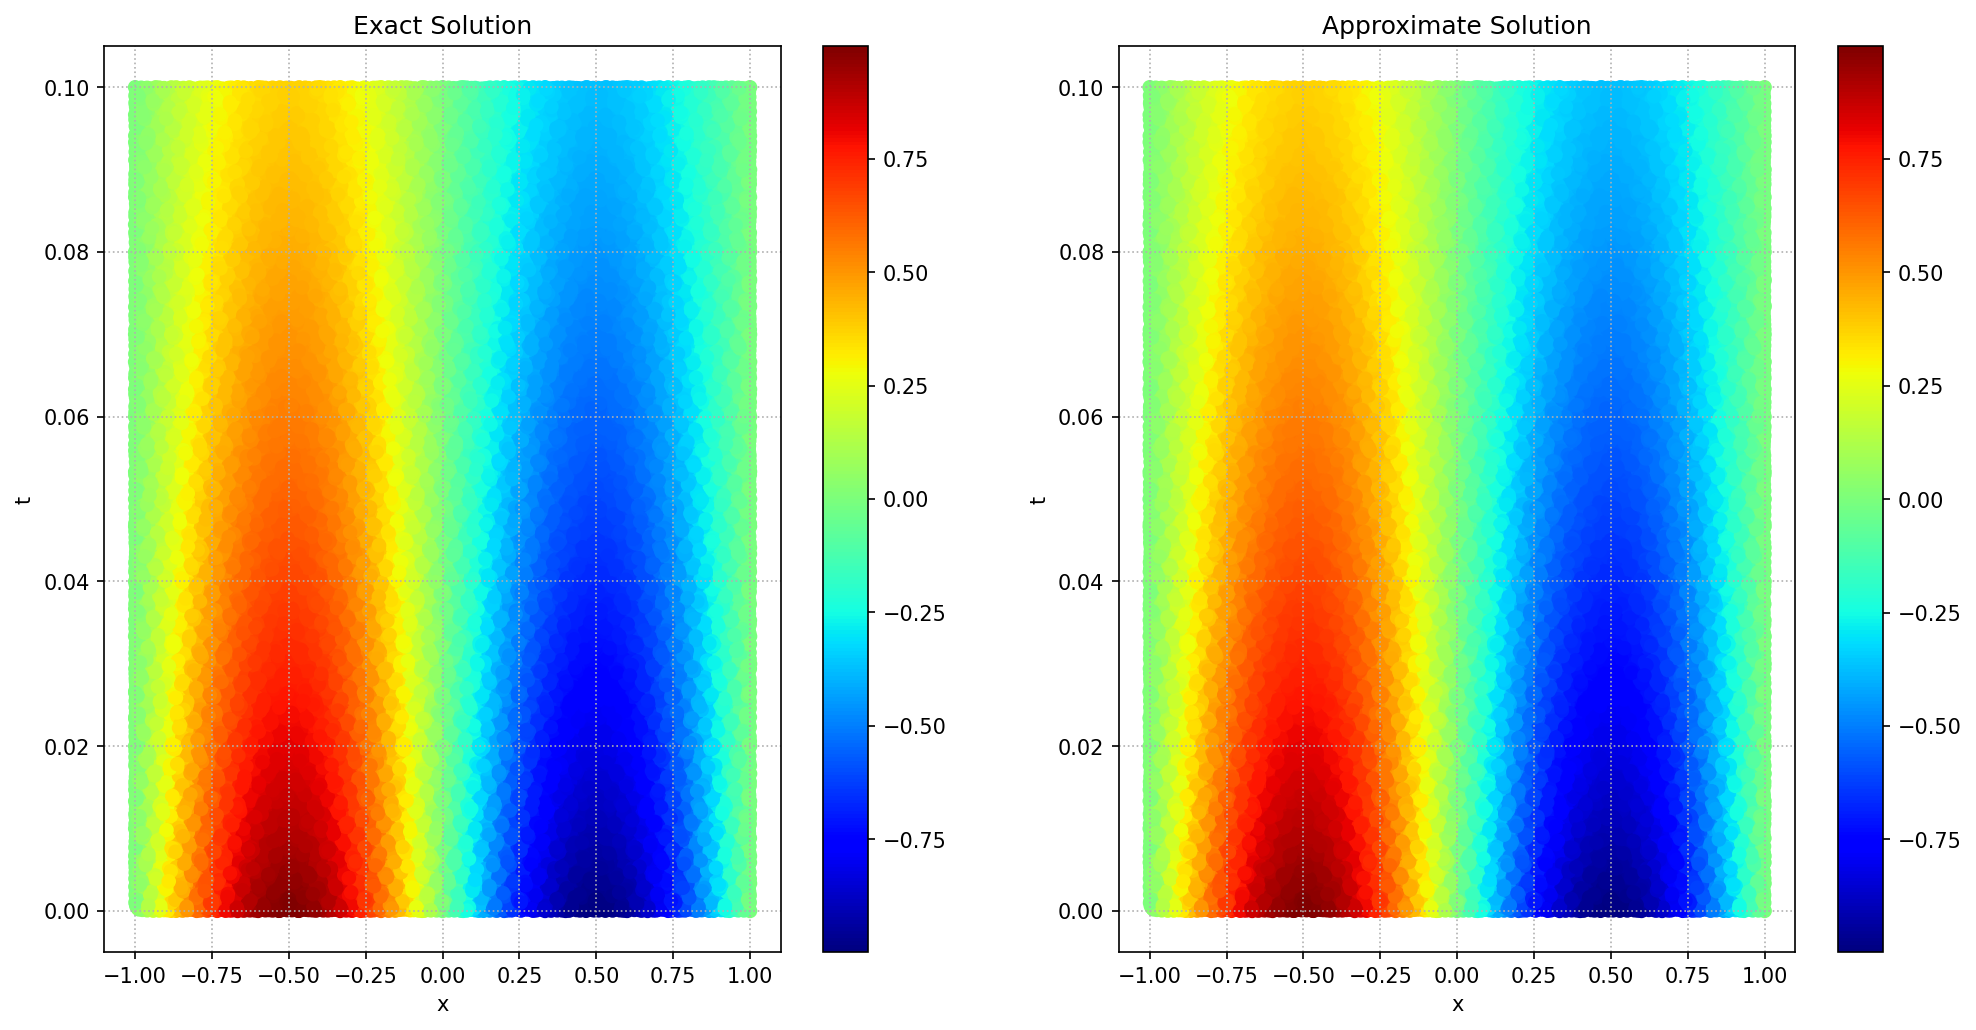

L2 Relative Error Norm:  0.014436772093176842 %


In [21]:
pinn.plotting()